In [1]:
import sqlite3
import pandas as pd
import seaborn as sns

## Report on Data Quality
The goal of this challenge is to find data quality issues in the database of the fictional Company X, concerning some leading questions, that I will go though one by one.
</br>
</br>
I used DBeaver to get a general overview about the database and to try out some queries in advance before I implemented them in Python.

### Question 1: Are the costs in the 'api_adwords_costs' table fully covered in the 'session_sources' table? Any campaigns where you see issues?

In [3]:
# connecting to the database and creating a cursor
conn = sqlite3.connect('challenge.db')
c = conn.cursor()

# specifying the query
query = '''SELECT * 
FROM session_sources  '''
c.execute(query)

# fetching the column names by hand
columns = []
for ele in c.description:
    columns.append(ele[0])

# fetching the results
results = pd.DataFrame(c.fetchall(), columns=columns)
results

,session_id,user_id,event_date,event_time,channel_name,campaign_name,campaign_id,market,cpc
0,session_id_660241,user_id_814496,2021-07-03,05:30:20,Affiliate,campaign_name_716,notset,NL,0.018
1,session_id_9812,user_id_752875,2021-07-19,16:00:40,Affiliate,campaign_name_108,notset,FR,0.000
2,session_id_780253,user_id_156905,2021-07-31,07:50:23,Affiliate,campaign_name_741,notset,DE,0.022
3,session_id_785994,user_id_540849,2021-07-16,09:43:00,Affiliate,campaign_name_741,notset,DE,0.000
4,session_id_1240841,user_id_275214,2021-07-12,08:36:41,Affiliate,campaign_name_893,notset,NL,0.188
...,...,...,...,...,...,...,...,...,...
1616697,session_id_716348,user_id_750466,2021-07-19,23:39:25,YouTube Video Ads,campaign_name_741,campaign_id_52,GB,3.329
1616698,session_id_975602,user_id_38349,2021-07-27,20:43:16,YouTube Video Ads,campaign_name_741,campaign_id_52,GB,0.000
1616699,session_id_41911,user_id_391102,2021-07-01,18:39:03,YouTube Video Ads,campaign_name_741,campaign_id_52,GB,1.984
1616700,session_id_1301781,user_id_750466,2021-07-15,21:18:49,YouTube Video Ads,campaign_name_741,campaign_id_52,GB,5.052


In [4]:
results['campaign_id'].value_counts()

notset             1088000
campaign_id_149      84644
campaign_id_126      35623
campaign_id_51       35186
campaign_id_56       32488
                    ...   
campaign_id_129          1
campaign_id_47           1
campaign_id_46           1
campaign_id_109          1
campaign_id_11           1
Name: campaign_id, Length: 164, dtype: int64

### Question 2: Are the conversions in the 'conversions' table stable over time? Any pattern?

We will group all the revenues over the dates when they were drawn and plot a chart, so we can visually see, if the revenues kept stable.

In [5]:
query = '''SELECT conv_date, SUM(revenue)
FROM conversions
GROUP BY conv_date  
'''
c.execute(query)
columns = []
for ele in c.description:
    columns.append(ele[0])
results = pd.DataFrame(c.fetchall(), columns=columns)
results

,conv_date,SUM(revenue)
0,2021-07-15,48140.04
1,2021-07-16,38388.89
2,2021-07-17,34721.01
3,2021-07-18,74555.65
4,2021-07-19,41764.69
5,2021-07-20,37678.05
6,2021-07-21,37516.15
7,2021-07-22,38041.52
8,2021-07-23,36188.87
9,2021-07-24,31101.09


/tmp/ipykernel_192921/1831358925.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45);


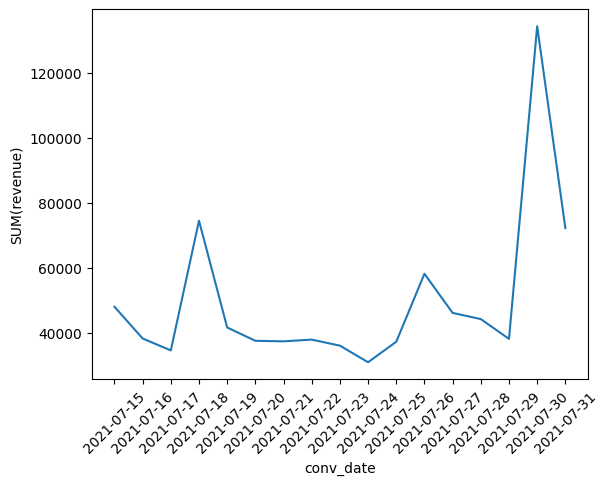

In [6]:
chart = sns.lineplot(x=results['conv_date'], y=results['SUM(revenue)'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

The conversion seems to have increased towards the end of the month. However, we would have to consider several months to deduce if 'end of the month' makes any pattern, because the increase could equally well be due to the beginning holiday period or any other reason.

### Question 3: Double check conversions ('conversions' table) with backend ('conversions_backend' table), any issues?

In [10]:
query = '''SELECT conversions_backend.conv_date, 
ROUND(SUM(conversions_backend.revenue),2) AS revenue_backend, 
ROUND(SUM(conversions.revenue),2) AS revenue_reported,
ROUND(SUM(conversions_backend.revenue),2)-ROUND(SUM(conversions.revenue),2) AS difference
FROM conversions_backend JOIN conversions
ON conversions_backend.conv_id = conversions.conv_id
GROUP BY conversions_backend.conv_date   
'''
c.execute(query)
columns = []
for ele in c.description:
    columns.append(ele[0])
results = pd.DataFrame(c.fetchall(), columns=columns)
results

,conv_date,revenue_backend,revenue_reported,difference
0,2021-07-15,48711.87,48140.04,571.83
1,2021-07-16,38979.81,38388.89,590.92
2,2021-07-17,35005.59,34721.01,284.58
3,2021-07-18,75421.04,74555.65,865.39
4,2021-07-19,42501.31,41764.69,736.62
5,2021-07-20,38286.54,37678.05,608.49
6,2021-07-21,37881.16,37516.15,365.01
7,2021-07-22,38967.53,38041.52,926.01
8,2021-07-23,36302.98,36188.87,114.11
9,2021-07-24,31355.41,31101.09,254.32


The reported revenues are lower than the revenues in the tables derived directly from the backend. Presumably there are some instances missing. Let's check for that.

In [29]:
query = '''SELECT COUNT(*)
FROM conversions_backend
'''
c.execute(query)
backend = c.fetchone()[0]

query = '''SELECT COUNT(*)
FROM conversions
'''
c.execute(query)
reported = c.fetchone()[0]

print(f'There are {backend} rows in the "conversions_backend" table and only {reported} rows in the reported \
"conversions" table. This means, in the reported table there are events missing.')

There are 17283 rows in the "conversions_backend" table and only 16954 rows in the reported "conversions" table. This means, in the reported table there are events missing.


### Question 4: Are attribution results consistent? Do you find any conversions where the 'ihc' values don't make sense?

### (Bonus) Do we have an issue with channeling? Are the number of sessions per channel stable over time?

### (Bonus) Any other issues?

Some suggestions that would make future work with the database easier:
1. The "campaign_id" in the "session_sources" table should be fully matched with "campaign_name". This way it will be easier to query SQL commands in future, without the need to convert into pandas dataframes to do the matching there. Since "campaign_name" isn't occuring anywhere else in the database, the company could also consider to entirely delete it, if not explicitely needed. This would reduce future risk of lacking data consistency.

In [16]:
# closing database, though in this case we did only read from it, so it's not really necessary
c.close()